<a href="https://colab.research.google.com/github/psedocode01/Final-Team10/blob/main/10%ED%8C%80_%EB%82%A8%EC%98%88%EC%A3%BC_%EA%B0%80%EC%84%A42_%EC%BD%94%EB%93%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 가설 2 검정: 유저는 높게 평가한 영화의 장르와 비슷한 장르를 선호한다.

In [ ]:
#폰트 추가

%%capture
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fm.fontManager.addfont('/usr/share/fonts/truetype/nanum/NanumGothic.ttf')
plt.rcParams['font.family'] = 'NanumGothic'

plt.rcParams['axes.unicode_minus'] = False

In [ ]:
# =========================================
# 0) 라이브러리
# =========================================
import pandas as pd
import numpy as np
from collections import Counter
from scipy.stats import ttest_ind, ttest_rel
import warnings
warnings.filterwarnings("ignore")

# =========================================
# 1) 데이터 로드
# =========================================
ratings = pd.read_csv("ratings.csv")
movies  = pd.read_csv("movies.csv")

# timestamp → 연도 추출
if "timestamp" in ratings.columns:
    ratings['year'] = pd.to_datetime(ratings['timestamp'], unit='s', errors='coerce').dt.year
else:
    raise ValueError("ratings.csv에 'timestamp' 컬럼이 없습니다.")

# 2020년 이후 데이터만 사용
ratings = ratings[ratings['year'] >= 2020].copy()

# =========================================
# 2) 결합 + 장르 리스트화
# =========================================
df = ratings.merge(movies[['movieId','title','genres']], on="movieId", how="left")
df['genres'] = df['genres'].fillna('(no genres listed)')
df['genre_list'] = df['genres'].apply(lambda x: x.split('|'))

MAX_GENRES_PER_MOVIE = 6
df['genre_list'] = df['genre_list'].apply(lambda gs: gs[:MAX_GENRES_PER_MOVIE])

# =========================================
# 3) 사용자별 Top 장르 정의 (상위 10% 평점 기준)
# =========================================
PERCENTILE = 90
MIN_USER_RATINGS = 5

user_top_genres = {}
user_top_movies = {}

for uid, g in df.groupby('userId'):
    if len(g) < MIN_USER_RATINGS:
        continue
    cutoff = np.percentile(g['rating'], PERCENTILE)
    top_rows = g[g['rating'] >= cutoff]

    top_genre_counter = Counter()
    for gs in top_rows['genre_list']:
        top_genre_counter.update(gs)

    top_genres = set(top_genre_counter.keys())
    if len(top_genres) == 0:
        continue

    user_top_genres[uid] = top_genres
    user_top_movies[uid] = set(top_rows['movieId'].tolist())

print(f"[INFO] Top 장르가 정의된 사용자 수(2020년 이후): {len(user_top_genres):,d}")

# =========================================
# 4) 레이블링: 해당 유저의 Top 장르 여부
# =========================================
def has_user_top_genre(row):
    uid = row['userId']
    tops = user_top_genres.get(uid, None)
    if not tops:
        return np.nan
    return int(any((g in tops) for g in row['genre_list']))

df['in_top_genre'] = df.apply(has_user_top_genre, axis=1)
anal_df = df.dropna(subset=['in_top_genre']).copy()
anal_df['in_top_genre'] = anal_df['in_top_genre'].astype(int)

# =========================================
# 5) 전체 표본 비교 (독립표본 t-test)
# =========================================
in_genre_ratings  = anal_df.loc[anal_df['in_top_genre']==1, 'rating'].values
out_genre_ratings = anal_df.loc[anal_df['in_top_genre']==0, 'rating'].values

print("=== [2020년 이후 전체 비교: 독립표본] ===")
print(f"N(in_top)={len(in_genre_ratings):,d}, N(other)={len(out_genre_ratings):,d}")
print(f"Mean(in_top)  = {np.mean(in_genre_ratings):.4f}")
print(f"Mean(other)   = {np.mean(out_genre_ratings):.4f}")

t_stat, p_val = ttest_ind(in_genre_ratings, out_genre_ratings, equal_var=False)
print(f"T={t_stat:.4f}, p={p_val:.6f}")

def cohens_d_ind(a, b):
    n1, n2 = len(a), len(b)
    s1, s2 = np.var(a, ddof=1), np.var(b, ddof=1)
    sp2 = ((n1-1)*s1 + (n2-1)*s2) / (n1+n2-2)
    d = (np.mean(a) - np.mean(b)) / np.sqrt(sp2)
    return d

print(f"Cohen's d (independent) = {cohens_d_ind(in_genre_ratings, out_genre_ratings):.4f}\n")

# =========================================
# 6) 사용자 단위 대응 비교
# =========================================
user_rows = []
for uid, g in anal_df.groupby('userId'):
    g_in  = g[g['in_top_genre']==1]['rating']
    g_out = g[g['in_top_genre']==0]['rating']
    if len(g_in)>0 and len(g_out)>0:
        user_rows.append({
            'userId': uid,
            'mean_in': g_in.mean(),
            'mean_out': g_out.mean(),
            'n_in': len(g_in),
            'n_out': len(g_out)
        })

per_user = pd.DataFrame(user_rows)
print("=== [2020년 이후 사용자 내 평균 비교: 대응표본] ===")
print(f"사용자 수(양집단 보유): {len(per_user):,d}")
print(per_user[['mean_in','mean_out','n_in','n_out']].describe().round(3))

t_rel, p_rel = ttest_rel(per_user['mean_in'], per_user['mean_out'])
diffs = per_user['mean_in'] - per_user['mean_out']

print(f"\nPaired T={t_rel:.4f}, p={p_rel:.6f}")
print(f"평균차 = {diffs.mean():.4f}")
print(f"Cohen's d (paired) = {diffs.mean()/diffs.std(ddof=1):.4f}\n")

# =========================================
# 7) 강건성 체크 (in/out 표본 최소 확보)
# =========================================
MIN_IN, MIN_OUT = 3, 3
robust = per_user[(per_user['n_in']>=MIN_IN)&(per_user['n_out']>=MIN_OUT)].copy()
if len(robust) >= 5:
    t_rel_r, p_rel_r = ttest_rel(robust['mean_in'], robust['mean_out'])
    diffs_r = robust['mean_in'] - robust['mean_out']
    print("=== [2020년 이후 강건성 체크] ===")
    print(f"유저 수: {len(robust):,d}")
    print(f"Paired T={t_rel_r:.4f}, p={p_rel_r:.6f}")
    print(f"평균차 = {diffs_r.mean():.4f}, Cohen's d(paired) = {diffs_r.mean()/diffs_r.std(ddof=1):.4f}\n")
else:
    print("=== [강건성 체크] 표본 부족 ===\n")

# =========================================
# 8) 결과 저장
# =========================================
per_user['delta_in_minus_out'] = diffs
per_user.sort_values('delta_in_minus_out', ascending=False).head(10).to_csv("2020_per_user_top10_positive.csv", index=False)
per_user.sort_values('delta_in_minus_out', ascending=True).head(10).to_csv("2020_per_user_top10_negative.csv", index=False)
per_user.to_csv("2020_per_user_effects.csv", index=False)

print("[DONE] 2020년 이후 분석 결과 저장 완료.")


[INFO] Top 장르가 정의된 사용자 수(2020년 이후): 12,970
=== [2020년 이후 전체 비교: 독립표본] ===
N(in_top)=2,103,236, N(other)=15,206
Mean(in_top)  = 3.5753
Mean(other)   = 3.1540
T=45.8894, p=0.000000
Cohen's d (independent) = 0.4009

=== [2020년 이후 사용자 내 평균 비교: 대응표본] ===
사용자 수(양집단 보유): 6,045
        mean_in  mean_out      n_in     n_out
count  6045.000  6045.000  6045.000  6045.000
mean      3.729     3.320   171.289     2.515
std       0.503     0.915   231.012     3.330
min       0.862     0.500     1.000     1.000
25%       3.443     3.000    39.000     1.000
50%       3.779     3.500    96.000     2.000
75%       4.070     4.000   216.000     3.000
max       5.000     4.500  5751.000   152.000

Paired T=40.6154, p=0.000000
평균차 = 0.4091
Cohen's d (paired) = 0.5224

=== [2020년 이후 강건성 체크] ===
유저 수: 1,859
Paired T=27.0031, p=0.000000
평균차 = 0.3931, Cohen's d(paired) = 0.6263

[DONE] 2020년 이후 분석 결과 저장 완료.


In [ ]:
# --- 한글 폰트 자동 설정 (Windows/Mac/Linux 공통) ---
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import font_manager

plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# 1) 시스템에 설치된 폰트 중 한국어 지원 후보
candidates = [
    "Malgun Gothic",        # Windows
    "AppleGothic",          # macOS
    "NanumGothic", "NanumSquare", "NanumBarunGothic",
    "Noto Sans CJK KR", "Noto Sans KR", "Spoqa Han Sans"
]

installed = {f.name for f in font_manager.fontManager.ttflist}
chosen = None
for name in candidates:
    if name in installed:
        chosen = name
        break

# 2) 선택 성공 → 바로 적용
if chosen:
    mpl.rcParams["font.family"] = chosen
    print(f"[font] Using system font: {chosen}")

# 3) 선택 실패 → (옵션) 사용자 지정 TTF 경로에서 로드 시도
#    -- 폰트 파일(.ttf)을 갖고 있다면 경로를 넣어 주세요.
#    ex) CUSTOM_FONT_PATH = "/path/to/NanumGothic.ttf"
else:
    CUSTOM_FONT_PATH = ""  # <- 여기에 로컬 TTF 경로 입력(없으면 빈 문자열 유지)
    if CUSTOM_FONT_PATH:
        font_manager.fontManager.addfont(CUSTOM_FONT_PATH)
        prop = font_manager.FontProperties(fname=CUSTOM_FONT_PATH)
        mpl.rcParams["font.family"] = prop.get_name()
        print(f"[font] Loaded custom font from file: {prop.get_name()}")
    else:
        # 마지막 수단: DejaVu(기본) 그대로 사용하되 경고 출력
        print("[font] ⚠ 한국어 폰트를 찾지 못했습니다. "
              "한글이 깨지면 한국어 TTF를 설치하거나 CUSTOM_FONT_PATH를 지정하세요.")

print("[font] Current font family:", mpl.rcParams["font.family"])


[font] Using system font: NanumGothic
[font] Current font family: ['NanumGothic']


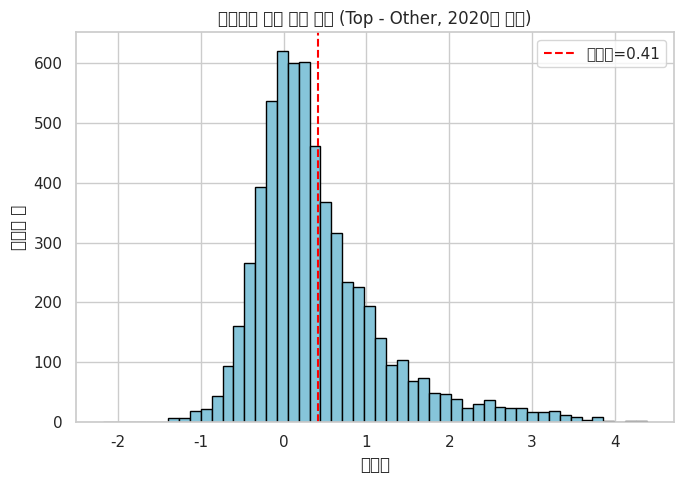

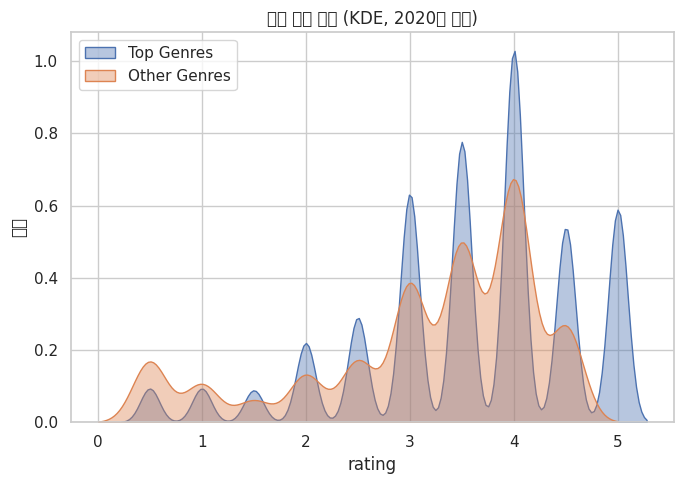

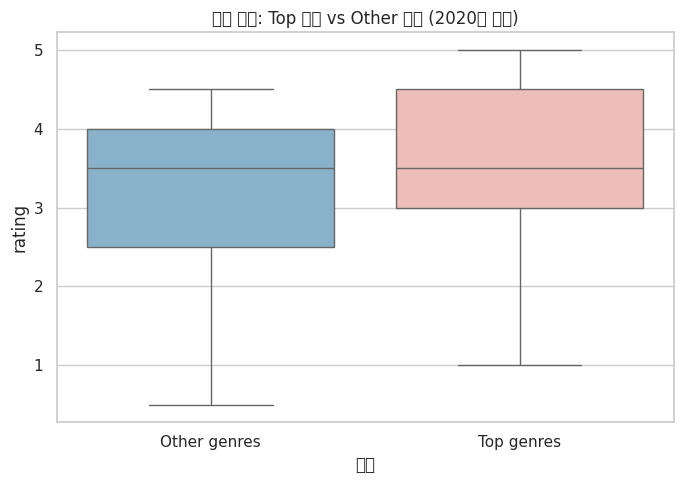

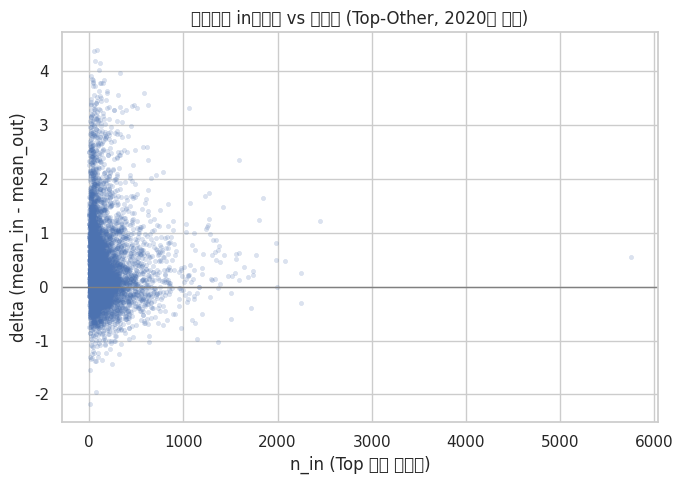

In [ ]:
# =========================================
# 9) 시각화 (2020년 이후 데이터)
# =========================================
import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_STATE = 42   # 샘플링 시 고정용 시드
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지
sns.set(style="whitegrid")

# --- (A) 사용자별 평균차 히스토그램: (Top - Other) ---
diffs = per_user['mean_in'] - per_user['mean_out']
fig, ax = plt.subplots(figsize=(7,5))
ax.hist(diffs, bins=50, color="#86c5da", edgecolor="black")
ax.axvline(diffs.mean(), linestyle="--", color="red",
           label=f"평균차={diffs.mean():.2f}")
ax.set_title("사용자별 평균 평점 차이 (Top - Other, 2020년 이후)")
ax.set_xlabel("평균차")
ax.set_ylabel("사용자 수")
ax.legend()
plt.tight_layout()
plt.savefig("2020_fig_user_diff_hist.png", dpi=150)
plt.show()

# --- (B) 평점 분포 KDE: Top vs Other ---
def _maybe_sample(arr, max_n=200_000, seed=42):
    if len(arr) > max_n:
        rng = np.random.default_rng(seed)
        idx = rng.choice(len(arr), size=max_n, replace=False)
        return arr[idx]
    return arr

in_sample  = _maybe_sample(in_genre_ratings, 200_000)
out_sample = _maybe_sample(out_genre_ratings, 200_000)

fig, ax = plt.subplots(figsize=(7,5))
sns.kdeplot(in_sample,  fill=True, alpha=0.4, label="Top Genres", ax=ax)
sns.kdeplot(out_sample, fill=True, alpha=0.4, label="Other Genres", ax=ax)
ax.set_title("평점 분포 비교 (KDE, 2020년 이후)")
ax.set_xlabel("rating")
ax.set_ylabel("밀도")
ax.legend()
plt.tight_layout()
plt.savefig("2020_fig_rating_kde.png", dpi=150)
plt.show()

# --- (C) 박스플롯: Top vs Other ---
max_rows = 300_000
plot_df = anal_df
if len(plot_df) > max_rows:
    plot_df = plot_df.sample(n=max_rows, random_state=RANDOM_STATE)

fig, ax = plt.subplots(figsize=(7,5))
sns.boxplot(x="in_top_genre", y="rating", data=plot_df,
            palette=["#7fb3d5", "#f5b7b1"], showfliers=False, ax=ax)
ax.set_xticklabels(["Other genres","Top genres"])
ax.set_title("평점 분포: Top 장르 vs Other 장르 (2020년 이후)")
ax.set_xlabel("그룹")
ax.set_ylabel("rating")
plt.tight_layout()
plt.savefig("2020_fig_boxplot.png", dpi=150)
plt.show()

# --- (D) 사용자별 표본수 vs 효과 크기 산점도 ---
robust_plot = per_user.copy()
robust_plot['delta'] = robust_plot['mean_in'] - robust_plot['mean_out']

fig, ax = plt.subplots(figsize=(7,5))
sns.scatterplot(data=robust_plot, x="n_in", y="delta",
                alpha=0.2, s=10, edgecolor=None, ax=ax)
ax.axhline(0, color="gray", lw=1)
ax.set_title("사용자별 in표본수 vs 평균차 (Top-Other, 2020년 이후)")
ax.set_xlabel("n_in (Top 장르 표본수)")
ax.set_ylabel("delta (mean_in - mean_out)")
plt.tight_layout()
plt.savefig("2020_fig_scatter_nin_delta.png", dpi=150)
plt.show()



In [ ]:
movies['genre_list'] = movies['genres'].fillna('').apply(lambda x: x.split('|'))


In [ ]:
df = ratings.merge(movies[['movieId', 'genre_list']], on='movieId', how='left')


In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
from scipy.stats import ttest_ind, ttest_rel

MIN_USER_RATINGS = 5
PERCENTILE = 90

# 0) 원본 로드
ratings = pd.read_csv("ratings.csv")
movies  = pd.read_csv("movies.csv")

# 1) movies에서 장르 리스트 생성
movies['genre_list'] = (
    movies['genres'].fillna('')
    .str.split('|')
    .apply(lambda lst: [g for g in lst if g and g != '(no genres listed)'])
)

# 2) ratings ↔ movies 조인 → 분석용 df (여기서부터 df를 덮어쓰지 말기!)
df = ratings.merge(movies[['movieId','genre_list']], on='movieId', how='left')

# 3) 연도 컬럼
df['timestamp'] = pd.to_numeric(df['timestamp'], errors='coerce')
df['year'] = pd.to_datetime(df['timestamp'], unit='s', errors='coerce').dt.year

# (진단) 필수 컬럼 확인
need = {'userId','movieId','rating','year','genre_list'}
missing = need - set(df.columns)
assert not missing, f"빠진 컬럼: {missing}"

# 4) 분할
df_pre  = df.loc[df['year'] < 2018].copy()
df_post = df.loc[df['year'] >= 2018].copy()

# 5) 과거 Top 장르 사전
user_top_genres_pre = {}
for uid, g in df_pre.groupby("userId"):
    if len(g) < MIN_USER_RATINGS:
        continue
    cutoff = np.percentile(g['rating'], PERCENTILE)
    top_rows = g[g['rating'] >= cutoff]
    c = Counter()
    for gl in top_rows['genre_list']:
        c.update(gl)
    tops = set(c.keys())
    if tops:
        user_top_genres_pre[uid] = tops

# 6) 이후 데이터 라벨링
def is_in_pre_top(row):
    tops = user_top_genres_pre.get(row['userId'])
    if not tops:
        return np.nan
    return int(any(g in tops for g in row['genre_list']))

df_post.loc[:, 'in_top_genre_pre'] = df_post.apply(is_in_pre_top, axis=1)
anal_post = df_post.dropna(subset=['in_top_genre_pre']).copy()

# 7) 전체 평균 비교
in_post  = anal_post.loc[anal_post['in_top_genre_pre']==1, 'rating']
out_post = anal_post.loc[anal_post['in_top_genre_pre']==0, 'rating']
print("=== [2018 이후 데이터 비교] ===")
print(f"Mean(in_top)={in_post.mean():.3f}, Mean(other)={out_post.mean():.3f}")
t_stat, p_val = ttest_ind(in_post, out_post, equal_var=False)
print(f"T={t_stat:.3f}, p={p_val:.5f}")

# 8) 사용자 단위 대응 비교
user_rows = []
for uid, g in anal_post.groupby("userId"):
    g_in  = g.loc[g['in_top_genre_pre']==1, 'rating']
    g_out = g.loc[g['in_top_genre_pre']==0, 'rating']
    if len(g_in)>0 and len(g_out)>0:
        user_rows.append({'userId':uid, 'mean_in':g_in.mean(), 'mean_out':g_out.mean()})
per_user_post = pd.DataFrame(user_rows)

t_rel, p_rel = ttest_rel(per_user_post['mean_in'], per_user_post['mean_out'])
print(f"Paired T={t_rel:.3f}, p={p_rel:.5f}")
print(f"평균차={(per_user_post['mean_in']-per_user_post['mean_out']).mean():.3f}")
print(per_user_post.head())


=== [2018 이후 데이터 비교] ===
Mean(in_top)=3.360, Mean(other)=3.387
T=-3.604, p=0.00031
Paired T=-5.616, p=0.00000
평균차=-0.071
   userId   mean_in  mean_out
0      28  3.917840     4.500
1      35  3.547170     4.000
2     141  3.724138     4.000
3     212  3.390805     2.750
4     213  4.220238     4.375


In [ ]:
# 사용자 단위 대응 비교
user_rows = []
for uid, g in anal_post.groupby("userId"):
    g_in  = g.loc[g['in_top_genre_pre']==1, 'rating']
    g_out = g.loc[g['in_top_genre_pre']==0, 'rating']
    if len(g_in) > 0 and len(g_out) > 0:
        user_rows.append({
            'userId': uid,
            'mean_in': g_in.mean(),
            'mean_out': g_out.mean()
        })

per_user_post = pd.DataFrame(user_rows)

# 대응표본 t-test
from scipy.stats import ttest_rel
t_rel, p_rel = ttest_rel(per_user_post['mean_in'], per_user_post['mean_out'])

# 평균 계산
avg_in  = per_user_post['mean_in'].mean()
avg_out = per_user_post['mean_out'].mean()
avg_diff= (per_user_post['mean_in'] - per_user_post['mean_out']).mean()

print("=== [2018 이후: 사용자 단위 대응 비교] ===")
print(f"평균(Top 장르)   = {avg_in:.3f}")
print(f"평균(Other 장르)= {avg_out:.3f}")
print(f"평균 차이       = {avg_diff:.3f}")
print(f"Paired T={t_rel:.3f}, p={p_rel:.5f}")


=== [2018 이후: 사용자 단위 대응 비교] ===
평균(Top 장르)   = 3.575
평균(Other 장르)= 3.646
평균 차이       = -0.071
Paired T=-5.616, p=0.00000


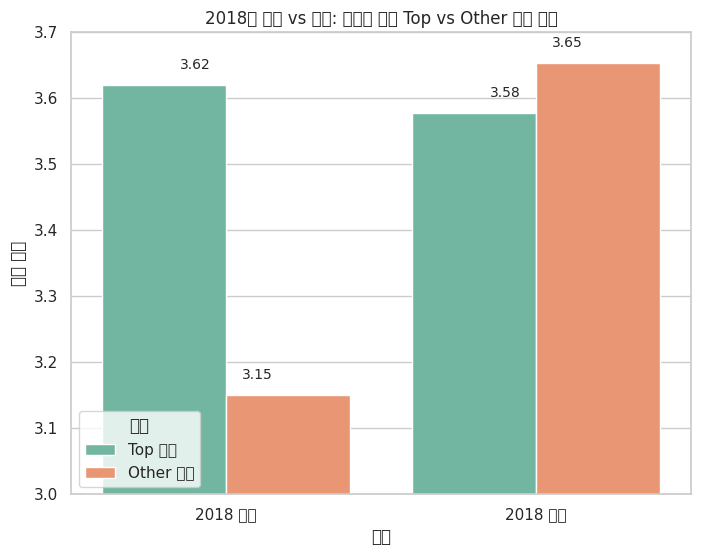

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 데이터 정리
data = pd.DataFrame({
    "시기": ["2018 이전", "2018 이전", "2018 이후", "2018 이후"],
    "집단": ["Top 장르", "Other 장르", "Top 장르", "Other 장르"],
    "평균": [3.62, 3.15, 3.578, 3.653]
})

plt.figure(figsize=(8,6))
sns.barplot(x="시기", y="평균", hue="집단", data=data, palette="Set2")

# 값 표시
for i, row in data.iterrows():
    plt.text(i//2 + (i%2)*0.2 - 0.1, row["평균"]+0.02, f"{row['평균']:.2f}",
             ha='center', va='bottom', fontsize=10)

plt.title("2018년 이전 vs 이후: 사용자 단위 Top vs Other 평균 평점")
plt.ylabel("평균 평점")
plt.ylim(3.0, 3.7)
plt.show()


In [ ]:
# ratings 컬럼 확인
print("=== ratings.csv 컬럼 ===")
print(ratings.columns.tolist())
print(ratings.info(), "\n")

# movies 컬럼 확인
print("=== movies.csv 컬럼 ===")
print(movies.columns.tolist())
print(movies.info())

=== ratings.csv 컬럼 ===
['userId', 'movieId', 'rating', 'timestamp']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22120254 entries, 0 to 22120253
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 675.1 MB
None 

=== movies.csv 컬럼 ===
['movieId', 'title', 'genres', 'genre_list']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87585 entries, 0 to 87584
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   movieId     87585 non-null  int64 
 1   title       87585 non-null  object
 2   genres      87585 non-null  object
 3   genre_list  87585 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.7+ MB
None


In [ ]:
ratings = pd.read_csv("ratings.csv")
movies  = pd.read_csv("movies.csv")

# ratings 컬럼 확인
print("=== ratings.csv 컬럼 ===")
print(ratings.columns.tolist())
print(ratings.info(), "\n")

# movies 컬럼 확인
print("=== movies.csv 컬럼 ===")
print(movies.columns.tolist())
print(movies.info())


=== ratings.csv 컬럼 ===
['userId', 'movieId', 'rating', 'timestamp']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32000204 entries, 0 to 32000203
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 976.6 MB
None 

=== movies.csv 컬럼 ===
['movieId', 'title', 'genres']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87585 entries, 0 to 87584
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  87585 non-null  int64 
 1   title    87585 non-null  object
 2   genres   87585 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.0+ MB
None


In [ ]:
# 1) 데이터 분할
df['year'] = pd.to_datetime(ratings.get('timestamp', pd.Timestamp("2010-01-01")), unit='s').dt.year
df_pre  = df[df['year'] < 2018]
df_post = df[df['year'] >= 2018]

# 2) 과거 Top 장르 정의 (2018년 이전 평점 기반)
user_top_genres_pre = {}

for uid, g in df_pre.groupby("userId"):
    if len(g) < MIN_USER_RATINGS:
        continue
    cutoff = np.percentile(g['rating'], PERCENTILE)
    top_rows = g[g['rating'] >= cutoff]

    top_genre_counter = Counter()
    for gs in top_rows['genre_list']:
        top_genre_counter.update(gs)

    top_genres = set(top_genre_counter.keys())
    if len(top_genres) > 0:
        user_top_genres_pre[uid] = top_genres

# 3) 이후 데이터에서 검정
df_post['in_top_genre_pre'] = df_post.apply(
    lambda row: int(any(g in user_top_genres_pre.get(row['userId'], []) for g in row['genre_list']))
                if row['userId'] in user_top_genres_pre else np.nan,
    axis=1
)

anal_post = df_post.dropna(subset=['in_top_genre_pre']).copy()

# 4) 전체 평균 비교
in_post  = anal_post.loc[anal_post['in_top_genre_pre']==1, 'rating']
out_post = anal_post.loc[anal_post['in_top_genre_pre']==0, 'rating']

print("=== [2018 이후 데이터 비교] ===")
print(f"Mean(in_top)={in_post.mean():.3f}, Mean(other)={out_post.mean():.3f}")
t_stat, p_val = ttest_ind(in_post, out_post, equal_var=False)
print(f"T={t_stat:.3f}, p={p_val:.5f}")

# 5) 사용자 단위 대응 비교
user_rows = []
for uid, g in anal_post.groupby("userId"):
    g_in = g[g['in_top_genre_pre']==1]['rating']
    g_out= g[g['in_top_genre_pre']==0]['rating']
    if len(g_in)>0 and len(g_out)>0:
        user_rows.append({'userId':uid, 'mean_in':g_in.mean(), 'mean_out':g_out.mean()})
per_user_post = pd.DataFrame(user_rows)

t_rel, p_rel = ttest_rel(per_user_post['mean_in'], per_user_post['mean_out'])
print(f"Paired T={t_rel:.3f}, p={p_rel:.5f}")
print(f"평균차={ (per_user_post['mean_in']-per_user_post['mean_out']).mean():.3f}")


=== [2018 이후 데이터 비교] ===
Mean(in_top)=3.360, Mean(other)=3.387
T=-3.604, p=0.00031
Paired T=-5.616, p=0.00000
평균차=-0.071


In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
from scipy.stats import ttest_ind

# ---------------------------------
# 준비: 전체 장르 리스트
# ---------------------------------
all_genres = sorted({g for gs in df['genre_list'] for g in gs})

# ---------------------------------
# 사용자별 Top 장르 집합 (이미 user_top_genres 존재한다고 가정)
# user_top_genres = {userId: set([...])}
# ---------------------------------

# 사용자별 Top 장르 여부를 장르별로 마크 (DataFrame화)
user_top_flags = []
for uid, tops in user_top_genres.items():
    row = {'userId': uid}
    for g in all_genres:
        row[g] = 1 if g in tops else 0
    user_top_flags.append(row)
user_top_df = pd.DataFrame(user_top_flags)

# ratings 데이터와 결합
df2 = df[['userId','movieId','rating','genre_list']].merge(user_top_df, on='userId', how='left')

# ---------------------------------
# 교차 효과 계산
# ---------------------------------
results = []

for top_g in all_genres:          # "Top 장르"
    users_with_top = set(user_top_df.loc[user_top_df[top_g]==1,'userId'])

    for eval_g in all_genres:     # "평가 대상 장르"
        # 평가 대상 장르가 포함된 영화 평가만 필터
        mask = df2['genre_list'].apply(lambda gs: eval_g in gs)
        sub = df2[mask]

        if len(sub)==0:
            continue

        # 그룹 나누기
        ratings_top    = sub[sub['userId'].isin(users_with_top)]['rating']
        ratings_nonTop = sub[~sub['userId'].isin(users_with_top)]['rating']

        if len(ratings_top)>5 and len(ratings_nonTop)>5:
            diff = ratings_top.mean() - ratings_nonTop.mean()
            t,p  = ttest_ind(ratings_top, ratings_nonTop, equal_var=False)
        else:
            diff, t, p = np.nan, np.nan, np.nan

        results.append({
            'Top_genre': top_g,
            'Eval_genre': eval_g,
            'Mean_TopUsers': ratings_top.mean() if len(ratings_top)>0 else np.nan,
            'Mean_nonTopUsers': ratings_nonTop.mean() if len(ratings_nonTop)>0 else np.nan,
            'Diff': diff,
            'T': t,
            'p': p,
            'n_Top': len(ratings_top),
            'n_nonTop': len(ratings_nonTop)
        })

results_df = pd.DataFrame(results)

# ---------------------------------
# 매트릭스 형태로 변환 (Diff 기준)
# ---------------------------------
pivot_diff = results_df.pivot(index="Top_genre", columns="Eval_genre", values="Diff")
pivot_pval = results_df.pivot(index="Top_genre", columns="Eval_genre", values="p")

print("=== 평균차 매트릭스 (Top - nonTop) ===")
print(pivot_diff.round(3))

print("\n=== p-value 매트릭스 ===")
print(pivot_pval.round(4))


In [ ]:
# =========================================
# 히트맵 시각화 (장르×장르 교차 효과)
# =========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from matplotlib import font_manager

# ── (선택) 한글 폰트 자동 적용 ───────────────────────────────────
plt.rcParams['axes.unicode_minus'] = False
candidates = ["Malgun Gothic","AppleGothic","NanumGothic","Noto Sans CJK KR","Noto Sans KR","Spoqa Han Sans"]
installed = {f.name for f in font_manager.fontManager.ttflist}
chosen = None
for name in candidates:
    if name in installed:
        chosen = name
        break

if chosen:
    mpl.rcParams["font.family"] = chosen
    print(f"[font] Using system font: {chosen}")
else:
    print("[font] ⚠ 한국어 폰트를 찾지 못했습니다.")


# pivot_diff, pivot_pval 이 이미 있다면 이 블록은 생략하세요.
# (결과 테이블에서 다시 만들고 싶을 때 사용)
# pivot_diff = results_df.pivot(index="Top_genre", columns="Eval_genre", values="Diff")
# pivot_pval = results_df.pivot(index="Top_genre", columns="Eval_genre", values="p")

# 장르 순서를 고정하고 싶다면 여기서 정렬
row_order = list(pivot_diff.index)
col_order = list(pivot_diff.columns)
pivot_diff = pivot_diff.loc[row_order, col_order]
pivot_pval = pivot_pval.loc[row_order, col_order]

# 발산형 컬러 스케일 설정 (0을 중심, 최대 절대값을 양끝)
absmax = np.nanmax(np.abs(pivot_diff.values))
vmin, vmax = -absmax, absmax

# ── (A) p-value로 유의/비유의 마스킹(회색 배경) ─────────────────
alpha = 0.05                    # 유의수준
sig_mask = (pivot_pval < alpha) # True=유의, False=비유의

plt.figure(figsize=(12, 9))
# 바탕: 비유의 영역을 연한 회색으로
sns.heatmap(pivot_diff, cmap="coolwarm", vmin=vmin, vmax=vmax,
            cbar=True, linewidths=0.5, linecolor="white",
            mask=sig_mask)  # 유의한 곳만 숨기고 비유의만 먼저 그림

# 위에: 유의한 영역을 본색으로 다시 덮어씀
sns.heatmap(pivot_diff, cmap="coolwarm", vmin=vmin, vmax=vmax,
            cbar=False, linewidths=0.5, linecolor="white",
            mask=~sig_mask)   # 이번엔 유의한 곳만 그림

plt.title("장르×장르 교차 효과 히트맵 (값: Top유저−비Top유저 평균차)")
plt.xlabel("평가 대상 장르 (Eval_genre)")
plt.ylabel("사용자 Top 장르 (Top_genre)")
plt.tight_layout()
plt.savefig("heatmap_genre_cross_effect.png", dpi=180)
plt.show()

# ── (B) 숫자/별표 주석 버전(옵션) ────────────────────────────────
# 작은 숫자까지 적으면 복잡해지니, 절대값이 큰 셀만 주석(예: |diff|>=0.08)
annot_thresh = 0.08
annot = pivot_diff.copy().astype(object)

# 별표 규칙: p<0.001:'***', p<0.01:'**', p<0.05:'*', else:''
stars = pd.DataFrame("", index=pivot_pval.index, columns=pivot_pval.columns)
stars[pivot_pval < 0.001] = "***"
stars[(pivot_pval >= 0.001) & (pivot_pval < 0.01)] = "**"
stars[(pivot_pval >= 0.01) & (pivot_pval < 0.05)] = "*"

for i in range(annot.shape[0]):
    for j in range(annot.shape[1]):
        val = pivot_diff.iat[i, j]
        if pd.notna(val) and abs(val) >= annot_thresh:
            annot.iat[i, j] = f"{val:+.2f}{stars.iat[i,j]}"
        else:
            annot.iat[i, j] = ""  # 표시 안 함

plt.figure(figsize=(12, 9))
sns.heatmap(pivot_diff, cmap="coolwarm", vmin=vmin, vmax=vmax,
            annot=annot, fmt="", annot_kws={"fontsize":9},
            linewidths=0.5, linecolor="white")
plt.title("장르×장르 교차 효과 (주석: 값 + 유의성 별표)")
plt.xlabel("평가 대상 장르 (Eval_genre)")
plt.ylabel("사용자 Top 장르 (Top_genre)")
plt.tight_layout()
plt.savefig("heatmap_genre_cross_effect_annot.png", dpi=180)
plt.show()

# ── (C) 유의성만 별도 표시(이진 히트맵) ─────────────────────────
plt.figure(figsize=(12, 9))
sns.heatmap(sig_mask.astype(int), cmap=sns.color_palette(["#eeeeee", "#2ecc71"]),
            cbar=False, linewidths=0.5, linecolor="white")
plt.title(f"유의성 매트릭스 (1: p<{alpha}, 0: p≥{alpha})")
plt.xlabel("평가 대상 장르 (Eval_genre)")
plt.ylabel("사용자 Top 장르 (Top_genre)")
plt.tight_layout()
plt.savefig("heatmap_significance_only.png", dpi=180)
plt.show()

In [ ]:
# =========================================
# 0) 라이브러리 & 한글 폰트 자동 설정
# =========================================
import pandas as pd
import numpy as np
from collections import Counter
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from matplotlib import font_manager

plt.rcParams['axes.unicode_minus'] = False
# 한글 폰트 자동 감지 (있으면 사용)
for _cand in ["Malgun Gothic","AppleGothic","NanumGothic","Noto Sans CJK KR","Noto Sans KR","Spoqa Han Sans"]:
    if _cand in {f.name for f in font_manager.fontManager.ttflist}:
        mpl.rcParams["font.family"] = _cand
        break
sns.set(style="whitegrid")

# =========================================
# 1) 데이터 로드 & 2020년 이후 필터
# =========================================
ratings = pd.read_csv("ratings.csv")
movies  = pd.read_csv("movies.csv")

if "timestamp" not in ratings.columns:
    raise ValueError("ratings.csv에 'timestamp' 컬럼이 없습니다.")

ratings['year'] = pd.to_datetime(ratings['timestamp'], unit='s', errors='coerce').dt.year
ratings = ratings[ratings['year'] >= 2020].copy()

# =========================================
# 2) 결합 + 장르 리스트화
# =========================================
df = ratings.merge(movies[['movieId','title','genres']], on="movieId", how="left")
df['genres'] = df['genres'].fillna('(no genres listed)')
df['genre_list'] = df['genres'].apply(lambda x: x.split('|'))
MAX_GENRES_PER_MOVIE = 6
df['genre_list'] = df['genre_list'].apply(lambda gs: gs[:MAX_GENRES_PER_MOVIE])

# 전체 장르 목록
all_genres = sorted({g for gs in df['genre_list'] for g in gs})

# =========================================
# 3) 사용자별 Top 장르 정의 (상위 10% 평점 기준)
# =========================================
PERCENTILE = 90
MIN_USER_RATINGS = 5

user_top_genres = {}
for uid, g in df.groupby('userId'):
    if len(g) < MIN_USER_RATINGS:
        continue
    cutoff = np.percentile(g['rating'], PERCENTILE)
    top_rows = g[g['rating'] >= cutoff]

    c = Counter()
    for gs in top_rows['genre_list']:
        c.update(gs)

    tops = set(c.keys())
    if tops:
        user_top_genres[uid] = tops

print(f"[INFO] Top 장르가 정의된 사용자 수(2020+): {len(user_top_genres):,}")

# =========================================
# 4) 장르×장르 교차 효과 계산
#    (행=사용자 Top 장르, 열=평가 대상 장르, 값=평균차 Top유저−비Top유저)
# =========================================
# 사용자별 Top 장르 플래그 테이블
rows = []
for uid, tops in user_top_genres.items():
    row = {'userId': uid}
    for g in all_genres: row[g] = 1 if g in tops else 0
    rows.append(row)
user_top_df = pd.DataFrame(rows)

# 평점 DF와 결합
df2 = df[['userId','movieId','rating','genre_list']].merge(user_top_df, on='userId', how='left')

results = []
for top_g in all_genres:
    users_with_top = set(user_top_df.loc[user_top_df[top_g]==1, 'userId'])
    if len(users_with_top) == 0:
        continue
    for eval_g in all_genres:
        sub = df2[df2['genre_list'].apply(lambda gs: eval_g in gs)]
        if len(sub) == 0:
            continue

        r_top    = sub[sub['userId'].isin(users_with_top)]['rating']
        r_nontop = sub[~sub['userId'].isin(users_with_top)]['rating']

        diff = t = p = np.nan
        if len(r_top) > 5 and len(r_nontop) > 5:
            diff = r_top.mean() - r_nontop.mean()
            t, p = ttest_ind(r_top, r_nontop, equal_var=False)

        results.append({
            'Top_genre': top_g, 'Eval_genre': eval_g,
            'Mean_TopUsers': r_top.mean() if len(r_top)>0 else np.nan,
            'Mean_nonTopUsers': r_nontop.mean() if len(r_nontop)>0 else np.nan,
            'Diff': diff, 'T': t, 'p': p,
            'n_Top': len(r_top), 'n_nonTop': len(r_nontop)
        })

results_df = pd.DataFrame(results)

pivot_diff = results_df.pivot(index="Top_genre", columns="Eval_genre", values="Diff").reindex(index=all_genres, columns=all_genres)
pivot_pval = results_df.pivot(index="Top_genre", columns="Eval_genre", values="p").reindex(index=all_genres, columns=all_genres)

# =========================================
# 5) 히트맵 시각화
# =========================================
# 공통 스케일: 0 중심 발산형
absmax = np.nanmax(np.abs(pivot_diff.values))
vmin, vmax = -absmax, absmax
alpha = 0.05
sig_mask = (pivot_pval < alpha)   # 유의한 곳(True)

# (A) 비유의 영역을 연한 회색으로, 유의한 영역만 본색
plt.figure(figsize=(12, 9))
# 먼저 비유의(=False)만 옅게
sns.heatmap(pivot_diff, cmap="coolwarm", vmin=vmin, vmax=vmax,
            cbar=True, linewidths=0.5, linecolor="white",
            mask=sig_mask)                 # 유의한 곳은 가리고 비유의만 그림
# 그 위에 유의한(True)만 본색으로
sns.heatmap(pivot_diff, cmap="coolwarm", vmin=vmin, vmax=vmax,
            cbar=False, linewidths=0.5, linecolor="white",
            mask=~sig_mask)                # 비유의는 가리고 유의만 그림
plt.title("장르×장르 교차 효과 (값=Top유저−비Top유저 평균차)")
plt.xlabel("평가 대상 장르 (Eval_genre)")
plt.ylabel("사용자 Top 장르 (Top_genre)")
plt.tight_layout()
plt.savefig("heatmap_genre_cross_effect.png", dpi=180)
plt.show()

# (B) 큰 효과(|diff|>=0.08)만 주석 + 유의성 별표
annot_thresh = 0.08
stars = pd.DataFrame("", index=pivot_pval.index, columns=pivot_pval.columns)
stars[pivot_pval < 0.001] = "***"
stars[(pivot_pval >= 0.001) & (pivot_pval < 0.01)] = "**"
stars[(pivot_pval >= 0.01) & (pivot_pval < 0.05)] = "*"

annot = pivot_diff.copy().astype(object)
for i in range(annot.shape[0]):
    for j in range(annot.shape[1]):
        val = pivot_diff.iat[i, j]
        if pd.notna(val) and abs(val) >= annot_thresh:
            annot.iat[i, j] = f"{val:+.2f}{stars.iat[i,j]}"
        else:
            annot.iat[i, j] = ""

plt.figure(figsize=(12, 9))
sns.heatmap(pivot_diff, cmap="coolwarm", vmin=vmin, vmax=vmax,
            annot=annot, fmt="", annot_kws={"fontsize":9},
            linewidths=0.5, linecolor="white")
plt.title("장르×장르 교차 효과 (주석: 효과값 + 유의성 별표)")
plt.xlabel("평가 대상 장르 (Eval_genre)")
plt.ylabel("사용자 Top 장르 (Top_genre)")
plt.tight_layout()
plt.savefig("heatmap_genre_cross_effect_annot.png", dpi=180)
plt.show()

# (C) 유의성만 이진 히트맵(1=유의, 0=비유의)
plt.figure(figsize=(12, 9))
sns.heatmap(sig_mask.astype(int),
            cmap=sns.color_palette(["#eeeeee", "#2ecc71"]),
            cbar=False, linewidths=0.5, linecolor="white")
plt.title(f"유의성 매트릭스 (1: p<{alpha}, 0: p≥{alpha})")
plt.xlabel("평가 대상 장르 (Eval_genre)")
plt.ylabel("사용자 Top 장르 (Top_genre)")
plt.tight_layout()
plt.savefig("heatmap_significance_only.png", dpi=180)
plt.show()

print("저장 완료:",
      "heatmap_genre_cross_effect.png,",
      "heatmap_genre_cross_effect_annot.png,",
      "heatmap_significance_only.png")
